In [1]:
import pandas as pd 
import os
from sklearn.utils import shuffle
import re 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

限制显存大小

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
assert len(gpus) > 0

try:
    # Currently, memory growth needs to be the same across GPUs
    tf.config.experimental.set_memory_growth(gpus[0], True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except :
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


载入数据集

In [3]:
text = []
sentiment = []

# 载入train
file_path = "../data/aclImdb/train"
for file in os.listdir(os.path.join(file_path, 'neg')):
    path = os.path.join(file_path, 'neg', file)
    with open(path) as f:
        text.append(f.readline())
sentiment = [0 for _ in os.listdir(os.path.join(file_path, 'neg'))]

for file in os.listdir(os.path.join(file_path, 'pos')):
    path = os.path.join(file_path, 'pos', file)
    with open(path) as f:
        text.append(f.readline())
pos_sentiment = [1 for _ in os.listdir(os.path.join(file_path, 'pos'))]
sentiment.extend(pos_sentiment)

# 载入test
text_test = []
sentiment_test = []
file_path = "../data/aclImdb/test"
for file in os.listdir(os.path.join(file_path, 'neg')):
    path = os.path.join(file_path, 'neg', file)
    with open(path) as f:
        text_test.append(f.readline())
sentiment_test = [0 for _ in os.listdir(os.path.join(file_path, 'neg'))]

for file in os.listdir(os.path.join(file_path, 'pos')):
    path = os.path.join(file_path, 'pos', file)
    with open(path) as f:
        text_test.append(f.readline())
pos_sentiment_test = [1 for _ in os.listdir(os.path.join(file_path, 'pos'))]
sentiment_test.extend(pos_sentiment_test)

# 合并train、test数据集
text.extend(text_test)
sentiment.extend(sentiment_test)
print(len(text),len(sentiment))

50000 50000


预处理数据

In [4]:
def preprocess_text(sentence):
    sentence = re.sub('(<)br\s*\/*(>)','',sentence) # Removing <br> as coming in reviews due to html pages
    sentence = re.sub('([?.!])',r' \1 ',sentence) # Putting space between word and punctuation
    sentence = re.sub('[^a-zA-z!.?]+',' ',sentence) # Replacing everythong other that a-zA-z and some punctuation
    sentence = re.sub('(\.\s+)+','. ',sentence)
    sentence = re.sub('(\s+[a-z]\s+)',' ',sentence) # Replacing every single character in between sentence
    sentence = sentence.lower() # lowering all words
    return sentence

processed_text = [preprocess_text(_) for _ in text]
print(len(processed_text), len(sentiment))

50000 50000


参数设置

In [5]:
max_length = 400
vocab_size = 60000
BATCH_SIZE = 128
EMBEDDING_SIZE = 128
EPOCHS = 64
learning_rate = 0.0001
kernel_l2 = 0.003
recurrent_l2 = 0.0005
activity_l2 = 0.0005

序列化数据

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(processed_text)

processed_text_vector = tokenizer.texts_to_sequences(processed_text)
padded_text_vector = tf.keras.preprocessing.sequence.pad_sequences(processed_text_vector,maxlen=max_length, 
                                                                   truncating='post', padding='post')
print(padded_text_vector.shape)

(50000, 400)


划分训练集与测试集

In [7]:
# 训练集，前25000条数据
train_text = padded_text_vector[:25000]
train_sentiment = sentiment[:25000]
train_text, train_sentiment = shuffle(train_text, np.array(train_sentiment), random_state=2)
# 测试集，后25000条数据
test_text = padded_text_vector[25000:]
test_sentiment = sentiment[25000:]
test_text, test_sentiment = shuffle(test_text, np.array(test_sentiment), random_state=3)

print(len(train_text), len(test_text), len(train_sentiment), len(test_sentiment))

25000 25000 25000 25000


划分训练集与验证集

In [8]:
text_train, text_val, sentiment_train, sentiment_val = train_test_split(train_text,train_sentiment, test_size=0.2,
                                                                       random_state=2)
print(len(text_train), len(text_val), len(sentiment_train), len(sentiment_val))

20000 5000 20000 5000


构建TextCNN模型

In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE, input_length=max_length))

model.add(tf.keras.layers.Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(kernel_l2)))
model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv1D(64, 4, activation='relu', kernel_regularizer=regularizers.l2(kernel_l2)))
model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 128)          7680000   
_________________________________________________________________
conv1d (Conv1D)              (None, 396, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 132, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 132, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 129, 64)           32832     
_______________________________________________________

训练模型

In [10]:
model.fit(x=text_train,y=sentiment_train, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True,
          validation_data=[text_val,sentiment_val], callbacks=[callback])

Train on 20000 samples, validate on 5000 samples
Epoch 1/64
20000/20000 [==============================] - 4s 215us/sample - loss: 1.1720 - acc: 0.5196 - val_loss: 1.0354 - val_acc: 0.6008
Epoch 2/64
20000/20000 [==============================] - 2s 107us/sample - loss: 0.9450 - acc: 0.5334 - val_loss: 0.8694 - val_acc: 0.6502
Epoch 3/64
20000/20000 [==============================] - 2s 106us/sample - loss: 0.8195 - acc: 0.6358 - val_loss: 0.7776 - val_acc: 0.7184
Epoch 4/64
20000/20000 [==============================] - 2s 107us/sample - loss: 0.7390 - acc: 0.6999 - val_loss: 0.6886 - val_acc: 0.7734
Epoch 5/64
20000/20000 [==============================] - 2s 106us/sample - loss: 0.5829 - acc: 0.8226 - val_loss: 0.5073 - val_acc: 0.8528
Epoch 6/64
20000/20000 [==============================] - 2s 106us/sample - loss: 0.4507 - acc: 0.8804 - val_loss: 0.4468 - val_acc: 0.8756
Epoch 7/64
20000/20000 [==============================] - 2s 104us/sample - loss: 0.3955 - acc: 0.9020 - val_lo

绘制训练结果

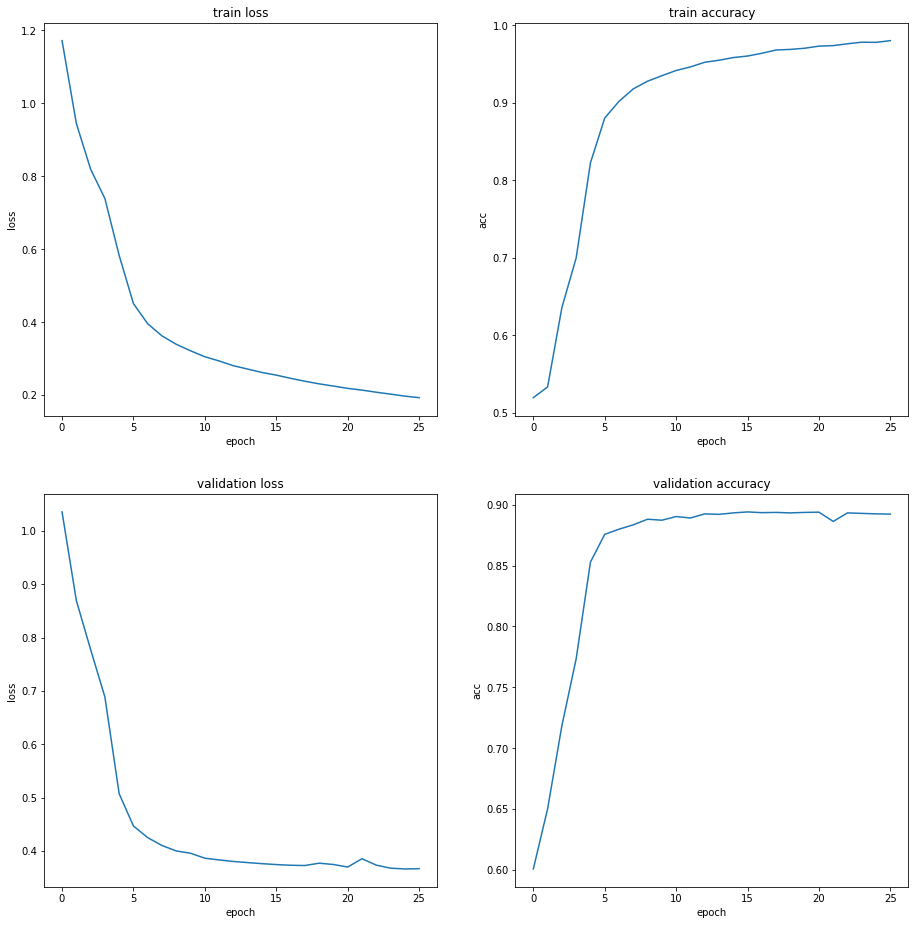

In [11]:
import matplotlib.pyplot as plt
from pylab import *

subplots_adjust(left=0.0,bottom=0.0,top=3,right=2)

plt.subplot(2, 2, 1)
plt.plot(model.history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("train loss")

plt.subplot(2, 2, 2)
plt.plot(model.history.history['acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title("train accuracy")

plt.subplot(2, 2, 3)
plt.plot(model.history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("validation loss")

plt.subplot(2, 2, 4)
plt.plot(model.history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title("validation accuracy")

plt.show()

在测试集上评估模型

In [12]:
model.evaluate(test_text, test_sentiment)

25000/25000 [==============================] - 2s 70us/sample - loss: 0.4030 - acc: 0.8838


[0.4030152672672272, 0.88376]

绘制模型图

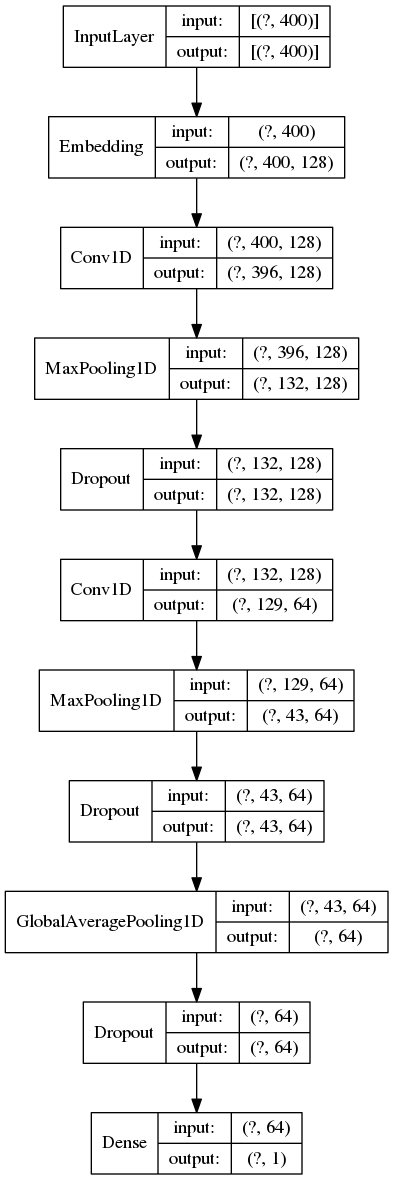

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="CNN_2_max.png", show_shapes=True, show_layer_names=False)

模型预测

In [14]:
x = '''I admit, the great majority of films released before say 1933 are just not for me. Of the dozen or so "major" silents I have viewed, one I loved (The Crowd), and two were very good (The Last Command and City Lights, that latter Chaplin circa 1931).<br /><br />So I was apprehensive about this one, and humor is often difficult to appreciate (uh, enjoy) decades later. I did like the lead actors, but thought little of the film.<br /><br />One intriguing sequence. Early on, the guys are supposed to get "de-loused" and for about three minutes, fully dressed, do some schtick. In the background, perhaps three dozen men pass by, all naked, white and black (WWI ?), and for most, their butts, part or full backside, are shown. Was this an early variation of beefcake courtesy of Howard Hughes?'''
x = preprocess_text(x)
vec = tokenizer.texts_to_sequences([x])
pad_vec = tf.keras.preprocessing.sequence.pad_sequences(vec, maxlen=max_length, truncating='post', padding='post')
result = model.predict(pad_vec)
print(result > 0.5)

[[ True]]
